In [27]:
# Let's import the necessary libraries
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn import tree
import imblearn
from os import system
from IPython.display import Image 
import graphviz
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [28]:
# After testing Decision Tree, Random Forest, KNN, AdaBoost, Gradient Boosting, and SVM, we found that KNN is the best model for this dataset, which was least overfitting model. 
# Let's import the dataset and split it into training and testing sets.
# During the data exploration, we found that the dataset is imbalanced. We will use SMOTE to balance the dataset.

# Import the dataset
data = pd.read_csv('drugs_train.csv')



In [29]:
data.head()

,id,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,...,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine,consumption_cocaine_last_month
0,train_0001,45-54,male,Masters degree,USA,Mixed-Black/Asian,57.6,57.3,50.1,47.8,...,42.8,22.4,used in last week,used over a decade ago,used in last day,used in last week,used in last day,never used,used in last week,No
1,train_0002,25-34,male,University degree,USA,Mixed-Black/Asian,47.8,67.0,45.7,47.8,...,33.8,30.8,used in last week,never used,used in last week,never used,used in last day,never used,never used,No
2,train_0003,18-24,female,University degree,USA,Mixed-Black/Asian,57.6,43.3,55.3,45.6,...,63.0,62.0,used in last month,never used,used in last day,used in last week,used in last week,used in last year,used in last month,No
3,train_0004,25-34,female,Masters degree,USA,Mixed-Black/Asian,71.8,31.2,43.6,56.3,...,63.0,71.1,used in last day,never used,used in last day,used in last decade,used in last day,never used,used in last decade,No
4,train_0005,18-24,male,"Some college or university, no certificate or ...",Australia,Mixed-Black/Asian,56.1,62.3,70.2,66.1,...,50.4,62.0,used in last week,never used,used in last month,used in last month,used in last day,used in last year,used in last month,No


In [30]:
# Drop the "id" column since it is not needed for our analysis
data.drop(['id'], axis=1, inplace=True)

In [31]:
# Some of our columns needs normaliaztion, so we will do that here
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_columns] = data[numeric_columns].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

data.head()


,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,personality_conscientiousness,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine,consumption_cocaine_last_month
0,45-54,male,Masters degree,USA,Mixed-Black/Asian,0.060927,0.072463,-0.030087,-0.02166,0.037012,-0.041722,-0.299163,used in last week,used over a decade ago,used in last day,used in last week,used in last day,never used,used in last week,No
1,25-34,male,University degree,USA,Mixed-Black/Asian,-0.037073,0.169463,-0.074087,-0.02166,0.060012,-0.131722,-0.215163,used in last week,never used,used in last week,never used,used in last day,never used,never used,No
2,18-24,female,University degree,USA,Mixed-Black/Asian,0.060927,-0.067537,0.021913,-0.04366,-0.000988,0.160278,0.096837,used in last month,never used,used in last day,used in last week,used in last week,used in last year,used in last month,No
3,25-34,female,Masters degree,USA,Mixed-Black/Asian,0.202927,-0.188537,-0.095087,0.06334,-0.181988,0.160278,0.187837,used in last day,never used,used in last day,used in last decade,used in last day,never used,used in last decade,No
4,18-24,male,"Some college or university, no certificate or ...",Australia,Mixed-Black/Asian,0.045927,0.122463,0.170913,0.16134,-0.075988,0.034278,0.096837,used in last week,never used,used in last month,used in last month,used in last day,used in last year,used in last month,No


In [32]:
# Our categorical columns need to be encoded, so we will do that here
# To not lose any information, we will save the original categorical columns in a json file for reference
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.astype('category'))

def map_func(column):
	return dict(enumerate(column.cat.categories))

gender_map = map_func(data.gender)
education_map = map_func(data.education)
country_map = map_func(data.country)
ethnicity_map = map_func(data.ethnicity)
consumption_alcohol_map = map_func(data.consumption_alcohol)
consumption_amphetamines_map = map_func(data.consumption_amphetamines)
consumption_caffeine_map = map_func(data.consumption_caffeine)
consumption_cannabis_map = map_func(data.consumption_cannabis)
consumption_chocolate_map = map_func(data.consumption_chocolate)
consumption_mushrooms_map = map_func(data.consumption_mushrooms)
consumption_nicotine_map = map_func(data.consumption_nicotine)
consumption_cocaine_last_month_map = map_func(data.consumption_cocaine_last_month)

data_dict = dict({'gender_map': gender_map,
		'education_map': education_map,
		'country_map': country_map,
		'ethnicity_map': ethnicity_map,
		'consumption_alcohol_map': consumption_alcohol_map,
		'consumption_amphetamines_map': consumption_amphetamines_map,
		'consumption_caffeine_map': consumption_caffeine_map,
		'consumption_cannabis_map': consumption_cannabis_map,
		'consumption_chocolate_map': consumption_chocolate_map,
		'consumption_mushrooms_map': consumption_mushrooms_map,
		'consumption_nicotine_map': consumption_nicotine_map,
		'consumption_cocaine_last_month_map': consumption_cocaine_last_month_map})


data[categorical_columns] = data[categorical_columns].apply(lambda x: x.cat.codes)


In [33]:
# As you see, we have encoded our categorical columns and normalized our numeric columns.
# Now we can split our data into training and test sets and then we can start our analysis.
data.head()

,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,personality_conscientiousness,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine,consumption_cocaine_last_month
0,3,1,5,6,2,0.060927,0.072463,-0.030087,-0.02166,0.037012,-0.041722,-0.299163,4,6,1,4,1,0,4,0
1,1,1,8,6,2,-0.037073,0.169463,-0.074087,-0.02166,0.060012,-0.131722,-0.215163,4,0,4,0,1,0,0,0
2,0,0,8,6,2,0.060927,-0.067537,0.021913,-0.04366,-0.000988,0.160278,0.096837,3,0,1,4,4,5,3,0
3,1,0,5,6,2,0.202927,-0.188537,-0.095087,0.06334,-0.181988,0.160278,0.187837,1,0,1,2,1,0,2,0
4,0,1,7,0,2,0.045927,0.122463,0.170913,0.16134,-0.075988,0.034278,0.096837,4,0,3,3,1,5,3,0


In [34]:
X = data.drop('consumption_cocaine_last_month', axis=1)
y = data.pop('consumption_cocaine_last_month')

Before Counter({0: 1373, 1: 127})
After Counter({0: 1373, 1: 1373})


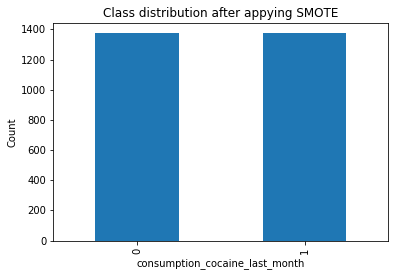

In [35]:
# Imbalanced data is a problem in machine learning.
# We will use SMOTE to balance our data.

import collections

counter = collections.Counter(y)
print('Before',counter)

oversample = imblearn.over_sampling.SMOTE(random_state=1)
X, y = oversample.fit_sample(X, y)

counter = collections.Counter(y)
print('After',counter)


pd.Series(y).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='consumption_cocaine_last_month', ylabel='Count')
plt.show()

In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.25, random_state=1)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn10 = KNeighborsClassifier(n_neighbors=10)

knn10.fit(Xtrain, ytrain)

ypred = knn10.predict(Xtest)

print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn10.score(Xtest, ytest)))



Accuracy of KNN classifier on test set: 0.86


In [38]:
# Let's save the model and the data dictionary for future use
import pickle

pickle.dump(knn10, open('knn10.sav', 'wb'))
pickle.dump(data_dict, open('data_dict.sav', 'wb'))

# Let's import the test dataset and make predictions
test_data = pd.read_csv('drugs_test.csv')

test_data.head()


,id,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,personality_conscientiousness,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine
0,test_0001,18-24,female,"Some college or university, no certificate or ...",USA,Mixed-Black/Asian,37.7,74.2,60.2,45.6,40.6,63.0,71.1,used in last day,never used,used in last day,used in last week,used in last day,used in last decade,used in last day
1,test_0002,45-54,male,Doctorate degree,USA,Other,62.3,47.6,73.1,43.5,60.9,56.5,71.1,used in last day,used over a decade ago,used in last day,used in last decade,used in last month,never used,used in last decade
2,test_0003,45-54,female,Professional certificate/ diploma,USA,Mixed-Black/Asian,56.1,52.6,34.9,58.5,58.4,56.5,38.8,used in last week,never used,used in last day,never used,used in last day,never used,never used
3,test_0004,35-44,male,"Some college or university, no certificate or ...",Australia,Mixed-Black/Asian,71.8,50.1,45.7,39.0,42.4,63.0,46.6,used in last decade,never used,used in last day,used in last day,used in last week,never used,used in last day
4,test_0005,35-44,male,Left school at 16 years,USA,Mixed-Black/Asian,62.3,41.2,19.2,39.0,22.3,42.8,38.8,used in last decade,used in last day,used in last day,used in last day,used in last week,used over a decade ago,used in last day


In [39]:

# Drop the "id" column since it is not needed for our analysis
test_data.drop(['id'], axis=1, inplace=True)

# Some of our columns needs normaliaztion, so we will do that here
numeric_columns = test_data.select_dtypes(include=['int64', 'float64']).columns
test_data[numeric_columns] = test_data[numeric_columns].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

test_data.head()

,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,personality_conscientiousness,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine
0,18-24,female,"Some college or university, no certificate or ...",USA,Mixed-Black/Asian,-0.168255,0.244132,0.081794,-0.055461,-0.124354,0.16154,0.20901,used in last day,never used,used in last day,used in last week,used in last day,used in last decade,used in last day
1,45-54,male,Doctorate degree,USA,Other,0.141960,-0.021868,0.220953,-0.081165,0.145953,0.09654,0.20901,used in last day,used over a decade ago,used in last day,used in last decade,used in last month,never used,used in last decade
2,45-54,female,Professional certificate/ diploma,USA,Mixed-Black/Asian,0.063776,0.028132,-0.191129,0.102434,0.112664,0.09654,-0.11399,used in last week,never used,used in last day,never used,used in last day,never used,never used
3,35-44,male,"Some college or university, no certificate or ...",Australia,Mixed-Black/Asian,0.261758,0.003132,-0.074624,-0.136244,-0.100386,0.16154,-0.03599,used in last decade,never used,used in last day,used in last day,used in last week,never used,used in last day
4,35-44,male,Left school at 16 years,USA,Mixed-Black/Asian,0.141960,-0.085868,-0.360493,-0.136244,-0.368029,-0.04046,-0.11399,used in last decade,used in last day,used in last day,used in last day,used in last week,used over a decade ago,used in last day


In [40]:
# Our categorical columns need to be encoded, so we will do that here

categorical_columns = test_data.select_dtypes(include=['object']).columns
test_data[categorical_columns] = test_data[categorical_columns].apply(lambda x: x.astype('category'))

test_data[categorical_columns] = test_data[categorical_columns].apply(lambda x: x.cat.codes)

test_data.head()

,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,personality_conscientiousness,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine
0,0,0,7,5,2,-0.168255,0.244132,0.081794,-0.055461,-0.124354,0.16154,0.20901,1,0,1,4,1,1,1
1,3,1,0,5,5,0.141960,-0.021868,0.220953,-0.081165,0.145953,0.09654,0.20901,1,6,1,2,3,0,2
2,3,0,6,5,2,0.063776,0.028132,-0.191129,0.102434,0.112664,0.09654,-0.11399,4,0,1,0,1,0,0
3,2,1,7,0,2,0.261758,0.003132,-0.074624,-0.136244,-0.100386,0.16154,-0.03599,2,0,1,1,4,0,1
4,2,1,1,5,2,0.141960,-0.085868,-0.360493,-0.136244,-0.368029,-0.04046,-0.11399,2,1,1,1,4,5,1


In [41]:

# Load the model and the data dictionary
knn10 = pickle.load(open('knn10.sav', 'rb'))
data_dict = pickle.load(open('data_dict.sav', 'rb'))

# Make predictions
predictions = knn10.predict(test_data)

# Save the predictions to a csv file
pd.DataFrame(predictions).to_csv('predictions.csv', index=False, header=False)



In [42]:
# Let's import our predictions and merge with the test data
predictions = pd.read_csv('predictions.csv', header=None)
predictions.columns = ['consumption_cocaine_last_month']

test_data = pd.read_csv('drugs_test.csv')
test_data = pd.concat([test_data, predictions], axis=1)

test_data.head()

,id,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,...,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine,consumption_cocaine_last_month
0,test_0001,18-24,female,"Some college or university, no certificate or ...",USA,Mixed-Black/Asian,37.7,74.2,60.2,45.6,...,63.0,71.1,used in last day,never used,used in last day,used in last week,used in last day,used in last decade,used in last day,1
1,test_0002,45-54,male,Doctorate degree,USA,Other,62.3,47.6,73.1,43.5,...,56.5,71.1,used in last day,used over a decade ago,used in last day,used in last decade,used in last month,never used,used in last decade,1
2,test_0003,45-54,female,Professional certificate/ diploma,USA,Mixed-Black/Asian,56.1,52.6,34.9,58.5,...,56.5,38.8,used in last week,never used,used in last day,never used,used in last day,never used,never used,0
3,test_0004,35-44,male,"Some college or university, no certificate or ...",Australia,Mixed-Black/Asian,71.8,50.1,45.7,39.0,...,63.0,46.6,used in last decade,never used,used in last day,used in last day,used in last week,never used,used in last day,0
4,test_0005,35-44,male,Left school at 16 years,USA,Mixed-Black/Asian,62.3,41.2,19.2,39.0,...,42.8,38.8,used in last decade,used in last day,used in last day,used in last day,used in last week,used over a decade ago,used in last day,1
